# Interpolating $\mathsf{\delta^{18}O}$ on a sphere

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.insert(0, '_libs/')

In [3]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic
% matplotlib inline

In [4]:
from NEMO_tools import int_profile, bin_profile, find_inland, reporj_NEMOgrid

In [5]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

In [6]:
def check_bounds(out, bounds_low, bounds_up):
    '''
    "What out of bounds becomes nan"
    '''
    out_adj = np.copy(out)
    for i in range(133):
        for j in range(17):
            if((out[i, j]<bounds_low[j]) | (out[i, j]>bounds_up[j])):
                out_adj[i, j]=np.nan
    return out_adj

In [7]:
def remove_nan(x, y, data):
    '''
    "Kriging does not like nan"
    '''
    data_temp = data[~np.isnan(data)]
    x_temp = x[~np.isnan(data)]
    y_temp = y[~np.isnan(data)]
    return x_temp, y_temp, data_temp

In [8]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/BGEP_d18O.mat')
x03 = MAT['d18O2003'][:, 1]; y03 = MAT['d18O2003'][:, 0]; z03 = MAT['d18O2003'][:, 2]; d18O03 = MAT['d18O2003'][:, 3]
x04 = MAT['d18O2004'][:, 1]; y04 = MAT['d18O2004'][:, 0]; z04 = MAT['d18O2004'][:, 2]; d18O04 = MAT['d18O2004'][:, 3]
x04[d18O04<0]=np.nan; y04[d18O04<0]=np.nan; z04[d18O04<0]=np.nan; d18O04[d18O04<0]=np.nan
x05 = MAT['d18O2005'][:, 1]; y05 = MAT['d18O2005'][:, 0]; z05 = MAT['d18O2005'][:, 2]; d18O05 = MAT['d18O2005'][:, 3]

In [9]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/HLY_d18O.mat')
xH = np.squeeze(MAT['lon'][:]); yH = np.squeeze(MAT['lat'][:]); zH = np.squeeze(MAT['dep'][:]); d18OH = np.squeeze(MAT['d18O'][:])

In [10]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/CBL_d18O.mat')
xC = np.squeeze(MAT['lon'][:]); yC = np.squeeze(MAT['lat'][:]); zC = np.squeeze(MAT['dep'][:]); d18OC = np.squeeze(MAT['d18O'][:])

In [11]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/ARK09_d18O.mat')
xA9 = np.squeeze(MAT['lon'][:]); yA9 = np.squeeze(MAT['lat'][:]); zA9 = np.squeeze(MAT['dep'][:]); d18OA9 = np.squeeze(MAT['d18O'][:])

In [12]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/ARK14_d18O.mat')
xA14 = np.squeeze(MAT['lon'][:]); yA14 = np.squeeze(MAT['lat'][:]); zA14 = np.squeeze(MAT['dep'][:]); d18OA14 = np.squeeze(MAT['d18O'][:])

In [13]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/NPEO_d18O.mat')
xNPEO = np.squeeze(MAT['lon'][:]); yNPEO = np.squeeze(MAT['lat'][:]); zNPEO = np.squeeze(MAT['dep'][:]); d18ONPEO = np.squeeze(MAT['d18O'][:])

In [14]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/Cooper_d18O.mat')
xCooper = np.squeeze(MAT['lon'][:]); yCooper = np.squeeze(MAT['lat'][:]); zCooper = np.squeeze(MAT['dep'][:]); d18OCooper = np.squeeze(MAT['d18O'][:])

In [15]:
nc_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ARCTIC_Ba/EXP00/*_1m_*_ptrc_T.nc')
nc_obj=nc.Dataset(nc_name[0])
deptht = nc_obj.variables['deptht'][:]

In [16]:
#deptht = np.array([5, 15, 25, 35, 45, 55, 75, 95, 115, 142, 182, 320, 511, 732, 1033, 1406, 1831, 2290, 2768, 3257, 3752, 4250, 4750, 5250]) 

In [17]:
BGEP_lons = np.hstack((x03, x04, x05))
BGEP_lats = np.hstack((y03, y04, y05))
BGEP_deps = np.hstack((z03, z04, z05))
BGEP_d18O   = np.hstack((d18O03, d18O04, d18O05))

In [18]:
x_all = np.hstack((x03, x04, x05, xH, xC, xA14, xNPEO, xCooper))
y_all = np.hstack((y03, y04, y05, yH, yC, yA14, yNPEO, yCooper))
z_all = np.hstack((z03, z04, z05, zH, zC, zA14, zNPEO, zCooper))
d18O_all = np.hstack((d18O03, d18O04, d18O05, d18OH, d18OC, d18OA14, d18ONPEO, d18OCooper))

In [19]:
tar_dep = 5250
dep_surf = deptht[deptht<tar_dep]

In [20]:
x_surf = x_all[z_all<tar_dep]; y_surf = y_all[z_all<tar_dep]; z_surf = z_all[z_all<tar_dep]; d18O_surf = d18O_all[z_all<tar_dep]

In [21]:
locx, locy, out_surf = int_profile(x_surf, y_surf, z_surf, d18O_surf, dep_surf, thres=2000)

In [22]:
x  = {'BGEP':BGEP_lons, 'HLY':xH, 'CBL':xC, 'ARK14':xA14, 'NPEO':xNPEO, 'Cooper':xCooper}
y  = {'BGEP':BGEP_lats, 'HLY':yH, 'CBL':yC, 'ARK14':yA14, 'NPEO':yNPEO, 'Cooper':yCooper}
z  = {'BGEP':BGEP_deps, 'HLY':zH, 'CBL':zC, 'ARK14':zA14, 'NPEO':zNPEO, 'Cooper':zCooper}
d18O = {'BGEP':BGEP_d18O, 'HLY':d18OH, 'CBL':d18OC, 'ARK14':d18OA14, 'NPEO':d18ONPEO, 'Cooper':d18OCooper}
x_cut   = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
y_cut   = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
z_cut   = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
d18O_cut  = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
x_int   = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
y_int   = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
z_int   = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
d18O_int  = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
x_trans = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
y_trans = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
x_cord  = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}
y_cord  = {'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'Cooper':[]}

keys = ['BGEP', 'HLY', 'CBL', 'ARK14', 'NPEO', 'Cooper']

In [23]:
for i in keys:
    x_cut[i] = x[i][z[i]<tar_dep]; y_cut[i] = y[i][z[i]<tar_dep]
    z_cut[i] = z[i][z[i]<tar_dep]; d18O_cut[i] = d18O[i][z[i]<tar_dep]
    x_int[i], y_int[i], d18O_int[i] = int_profile(x_cut[i], y_cut[i], z_cut[i], d18O_cut[i], dep_surf, thres=2000)

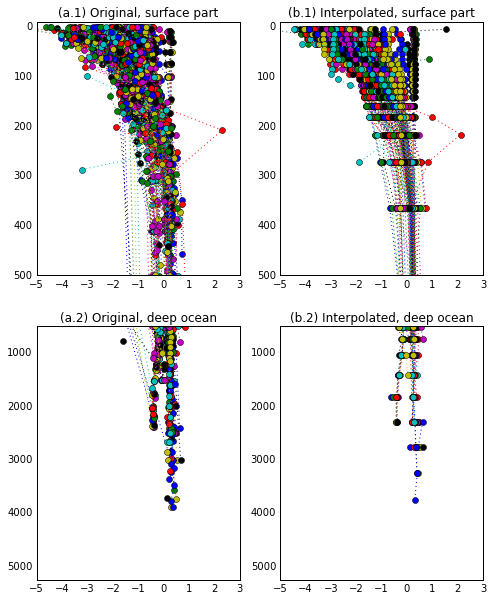

In [24]:
fig = plt.figure(figsize=(8, 10))
# Axis
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
AX = [ax1, ax2, ax3, ax4]
for i in range(4):
    AX[i].set_xlim(-5, 3)
    AX[i].xaxis.set_tick_params(size=0)
    AX[i].yaxis.set_tick_params(size=0)
# Fig1
ax1.set_ylim(-10, 500); ax1.invert_yaxis()
for i in range(len(locx)):
    ax1.plot(d18O_all[x_all==locx[i]], z_all[x_all==locx[i]], 'o:')
ax1.set_title('(a.1) Original, surface part', fontsize=12)
# Fig2
ax2.set_ylim(-10, 500); ax2.invert_yaxis()
ax2.plot(out_surf.T, dep_surf, 'o:')
ax2.set_title('(b.1) Interpolated, surface part')
# Fig3
ax3.set_ylim(500, tar_dep); ax3.invert_yaxis()
for i in range(len(locx)):
    ax3.plot(d18O_all[x_all==locx[i]], z_all[x_all==locx[i]], 'o:')
ax3.set_title('(a.2) Original, deep ocean', fontsize=12)
# Fig4
ax4.set_ylim(500, tar_dep); ax4.invert_yaxis()
ax4.plot(out_surf.T, dep_surf, 'o:')
ax4.set_title('(b.2) Interpolated, deep ocean')

In [25]:
p1=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90)
# create frame
res=40
xylim = [1e7, 1.7e7]
listx_trans = np.linspace(xylim[0], xylim[1], res)
listy_trans = np.linspace(xylim[0], xylim[1], res)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)
# convert frame back to lat/lon
listx, listy = p1(listx_trans, listy_trans, inverse=True)
gridx, gridy = p1(gridx_trans, gridy_trans, inverse=True)

In [26]:
# for CTD's locs
x_all_trans, y_all_trans = p1(locx, locy)
for i in keys:
    x_trans[i], y_trans[i] = p1(x_int[i], y_int[i])

data points participated: 137
data points participated: 206
data points participated: 209
data points participated: 210
data points participated: 212
data points participated: 200
data points participated: 202
data points participated: 200
data points participated: 197
data points participated: 196
data points participated: 196
data points participated: 195
data points participated: 194
data points participated: 194
data points participated: 188
data points participated: 187
data points participated: 177
data points participated: 164
data points participated: 146
data points participated: 104
data points participated: 73
data points participated: 28
data points participated: 25
data points participated: 21
data points participated: 24
data points participated: 8
data points participated: 3


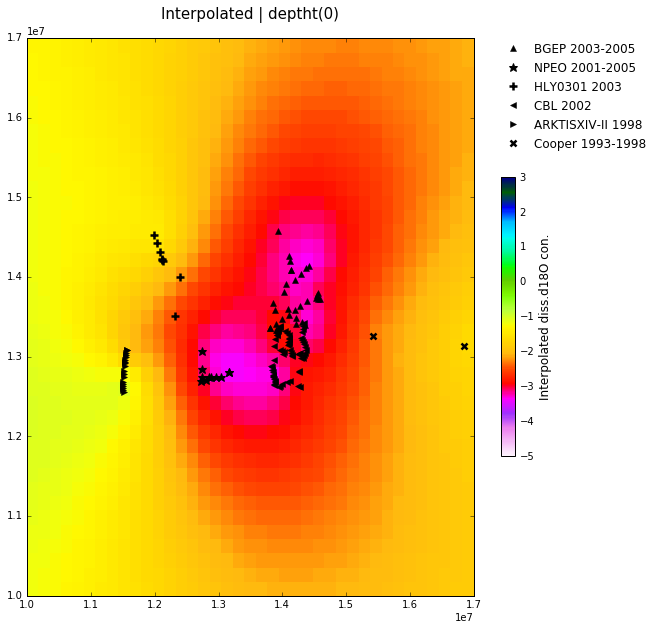

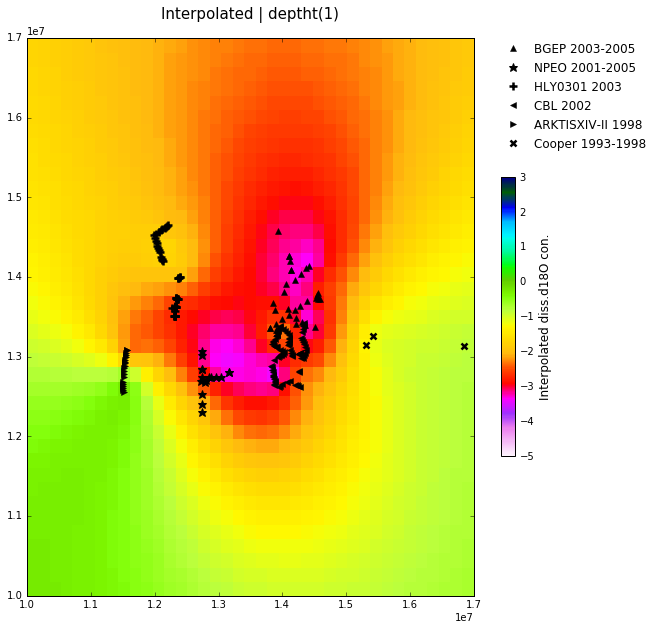

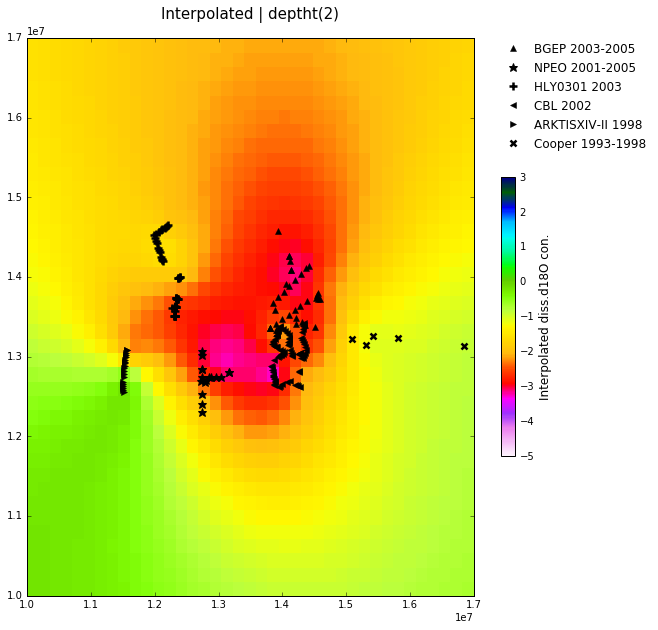

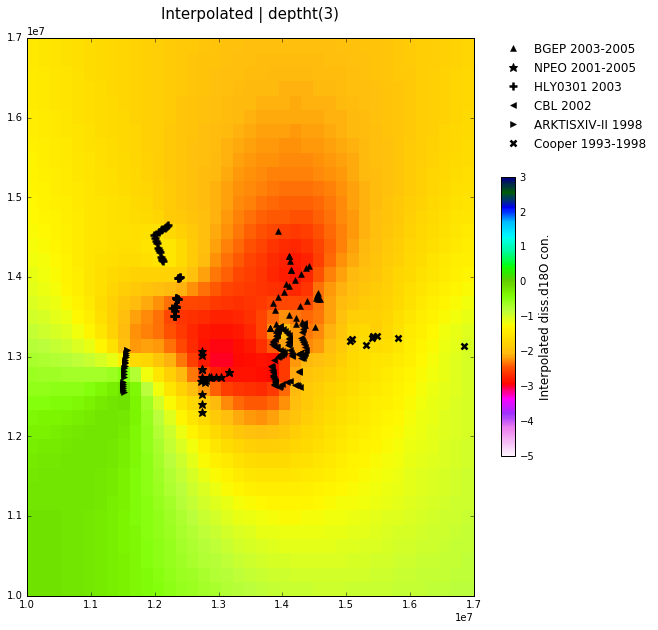

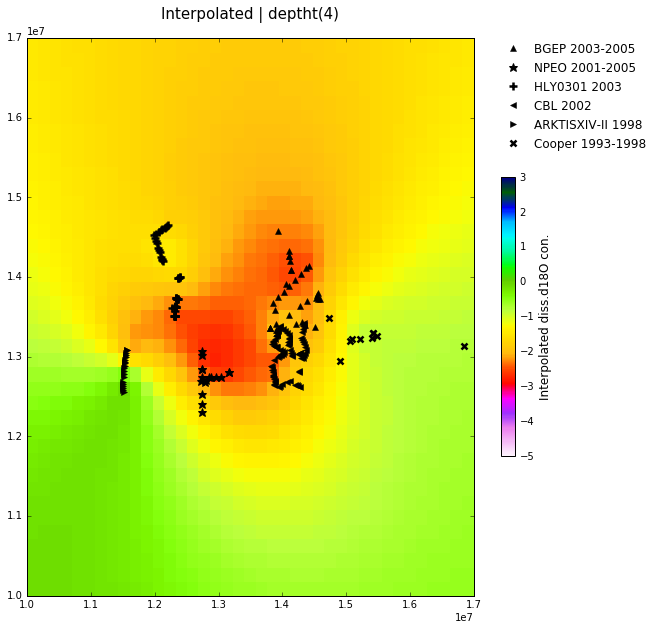

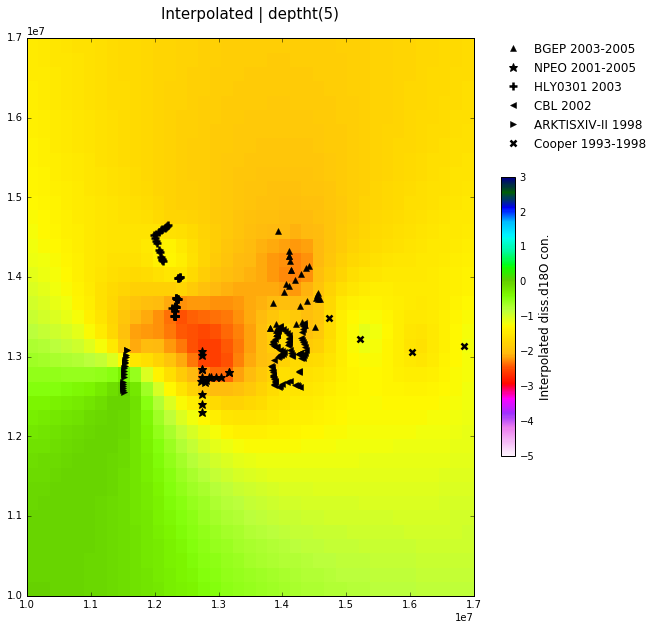

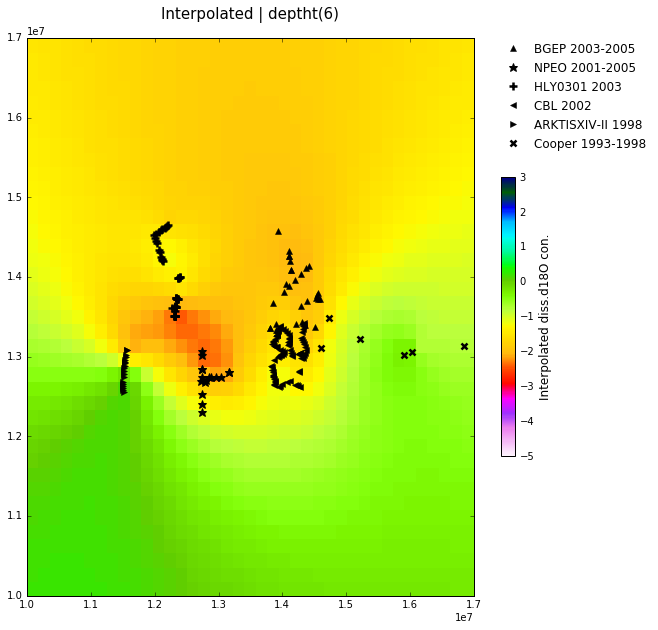

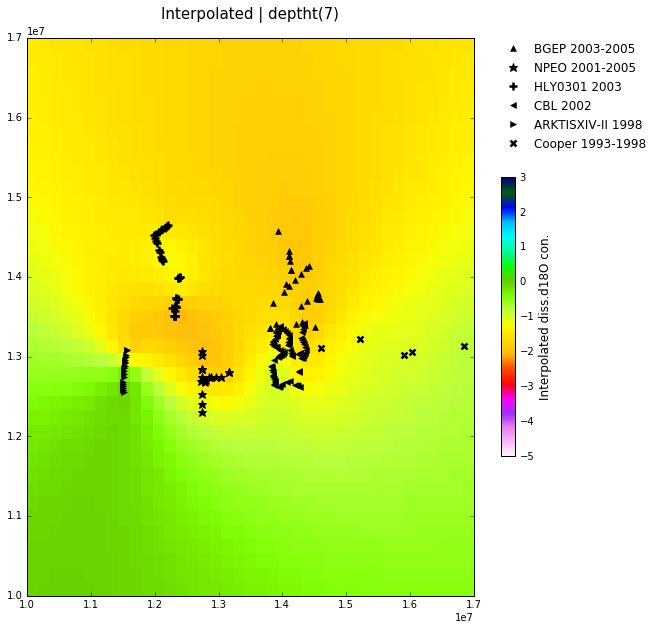

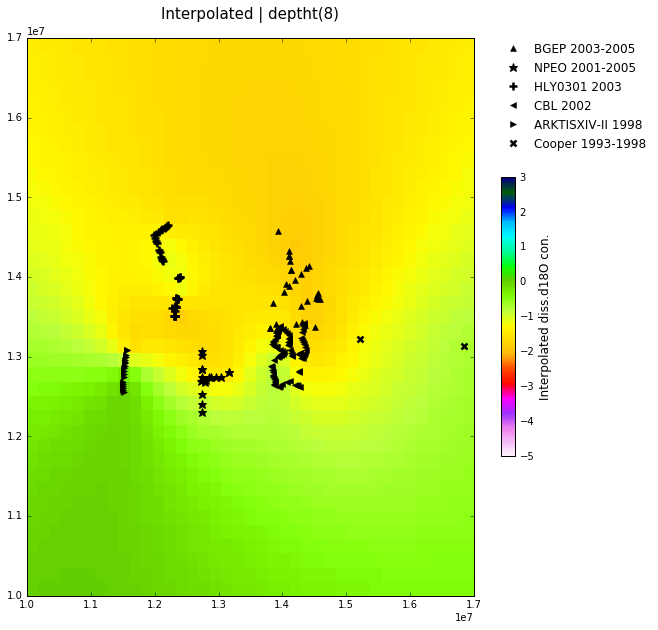

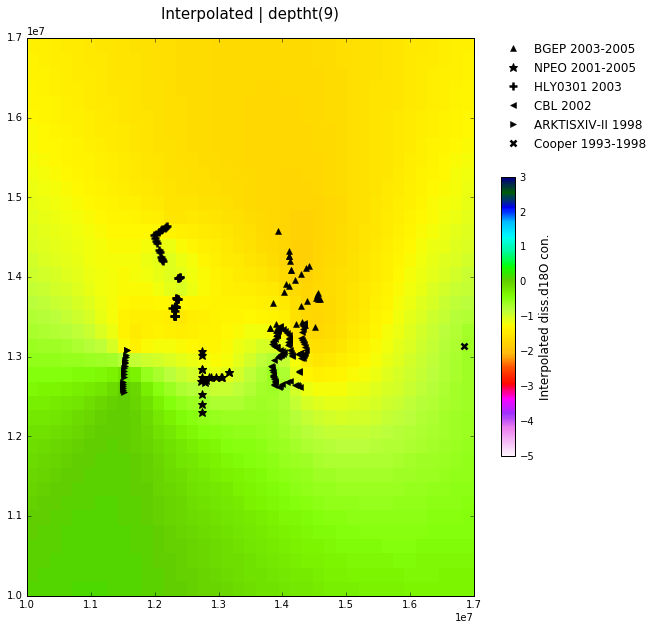

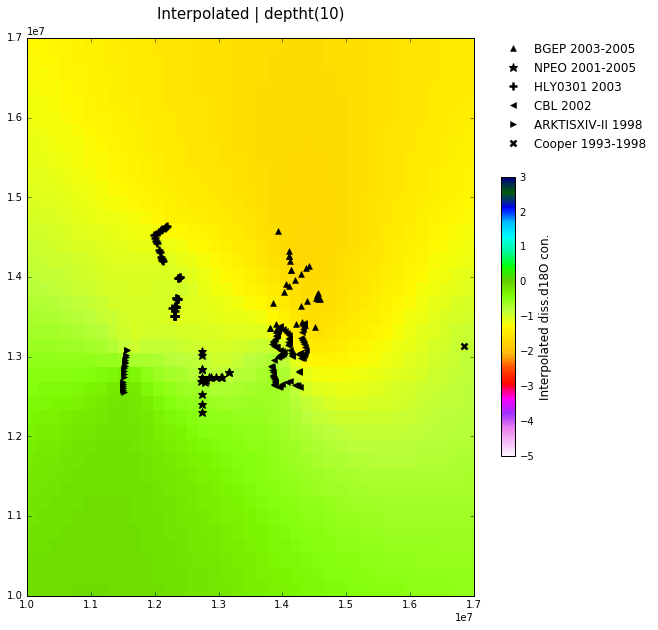

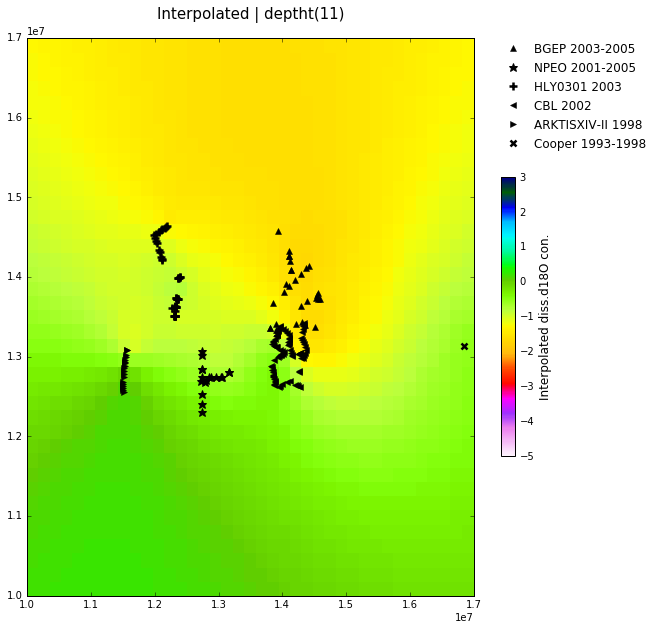

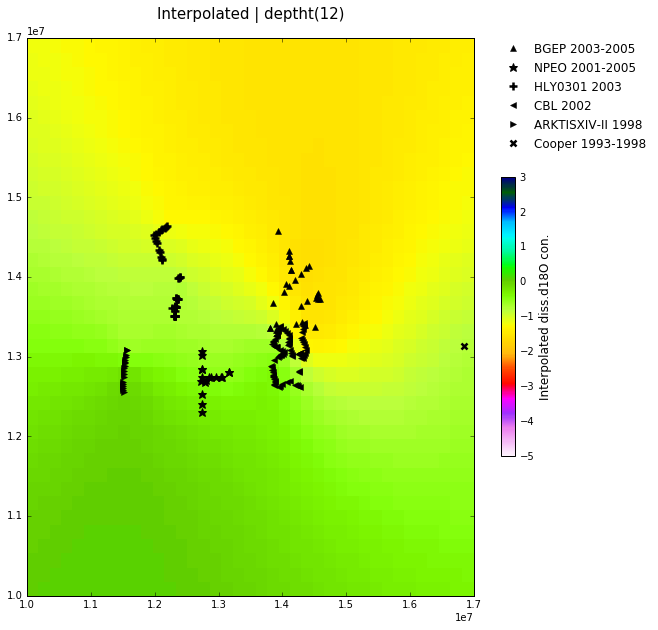

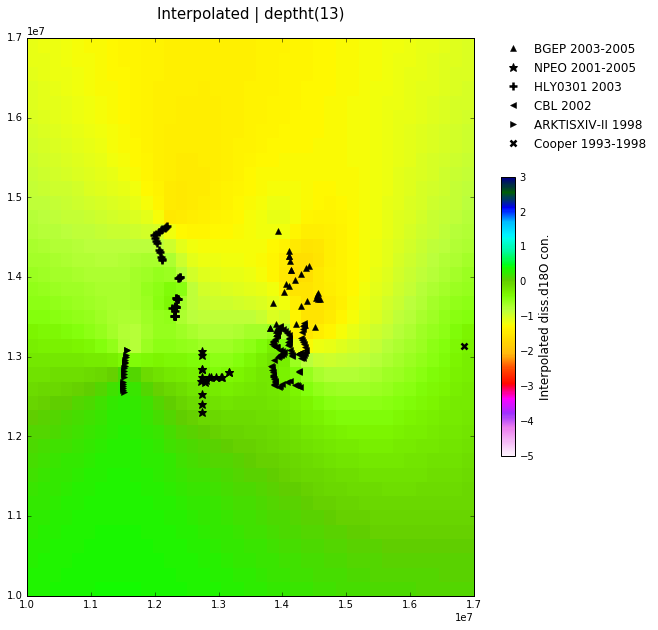

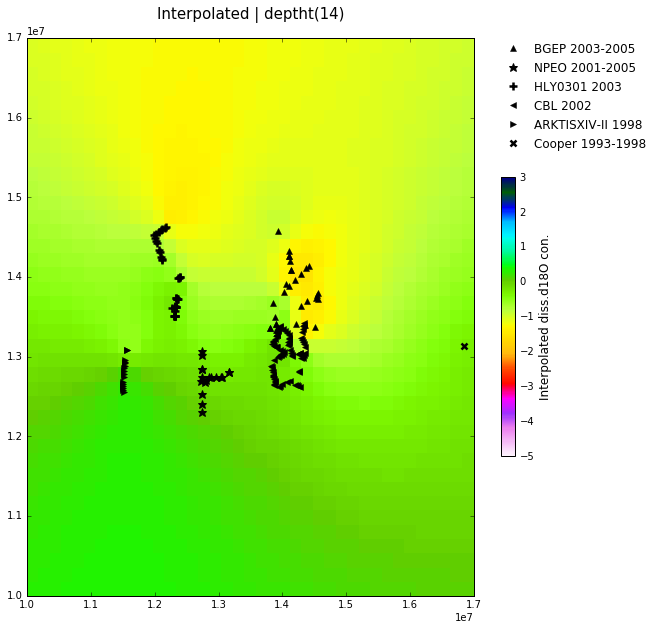

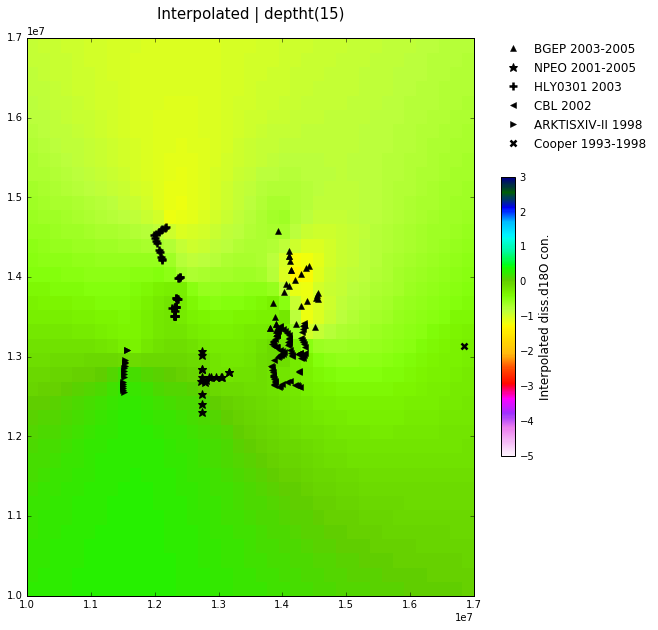

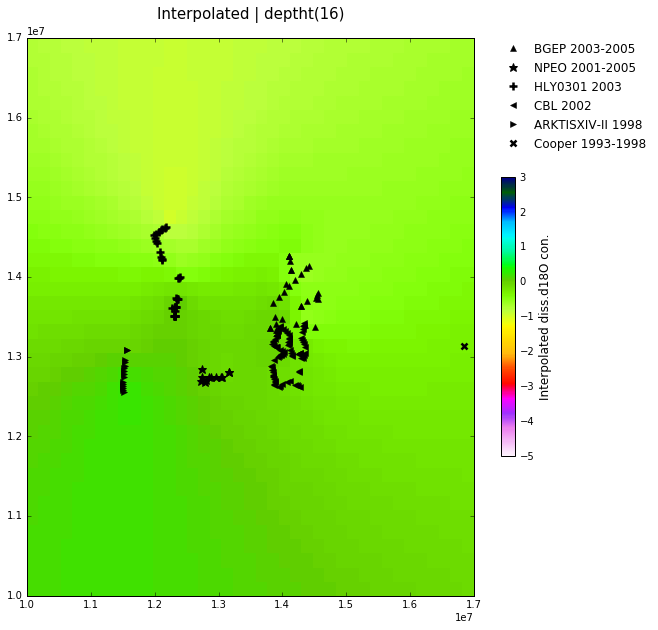

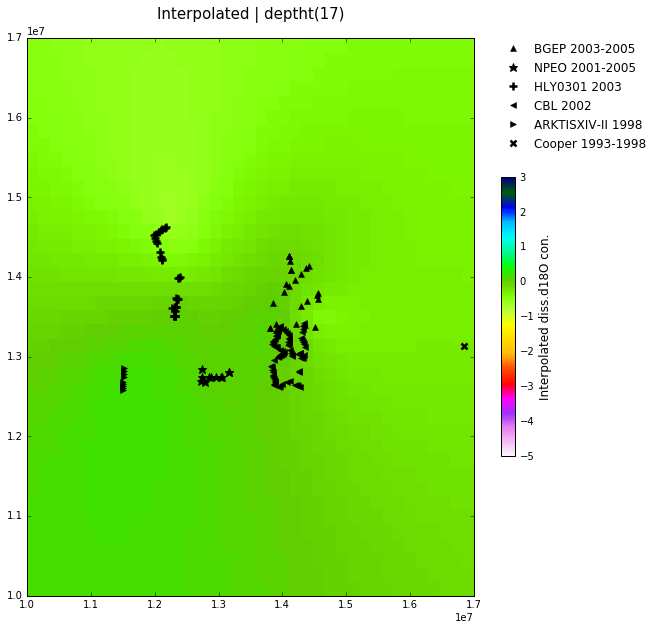

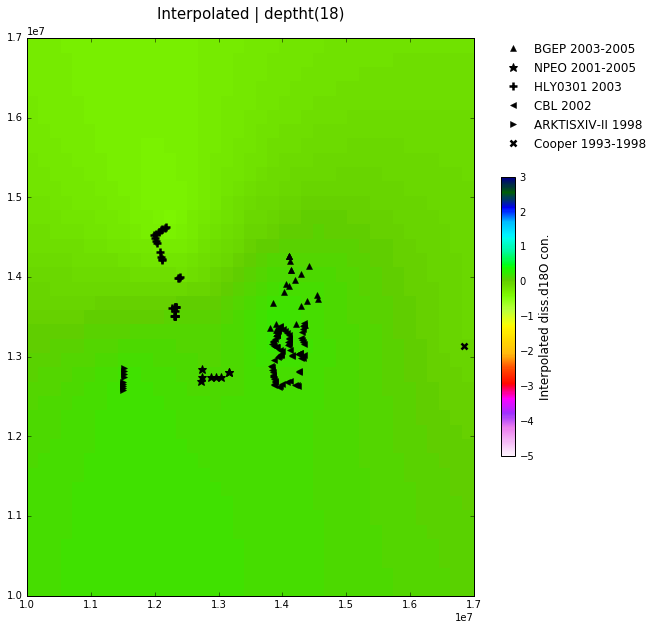

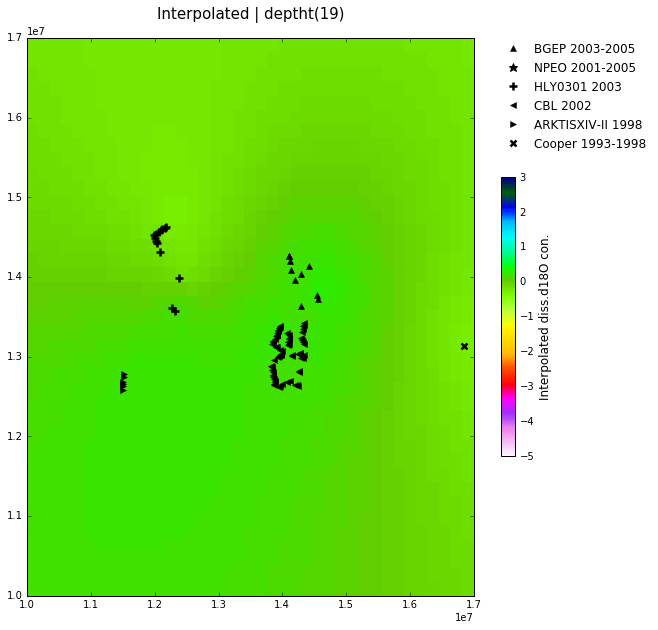

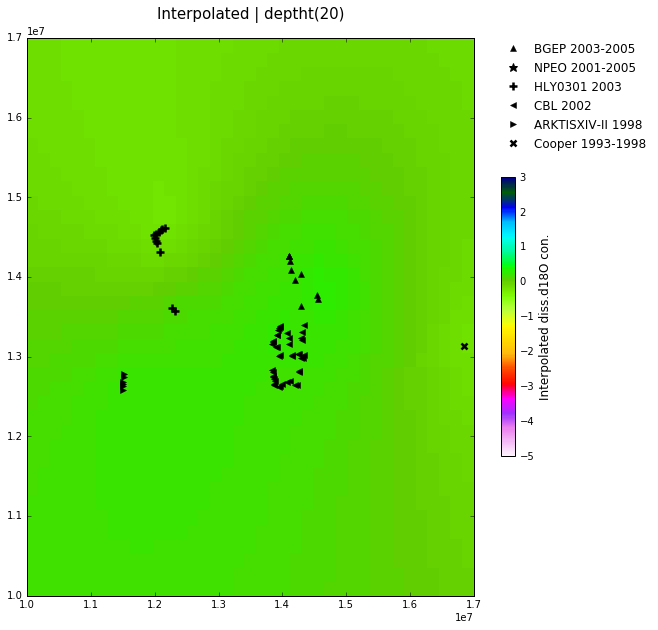

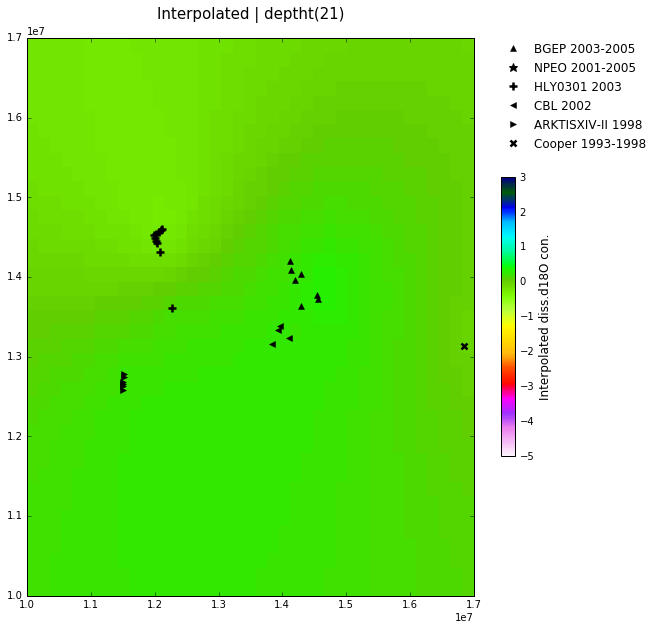

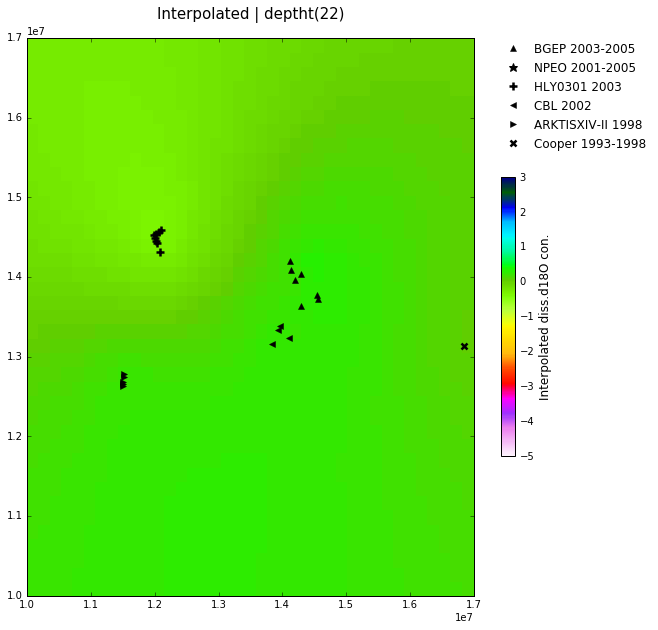

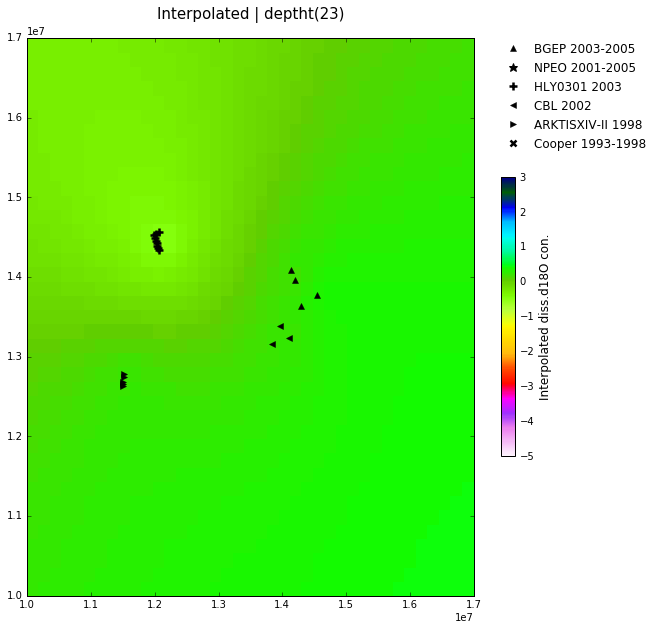

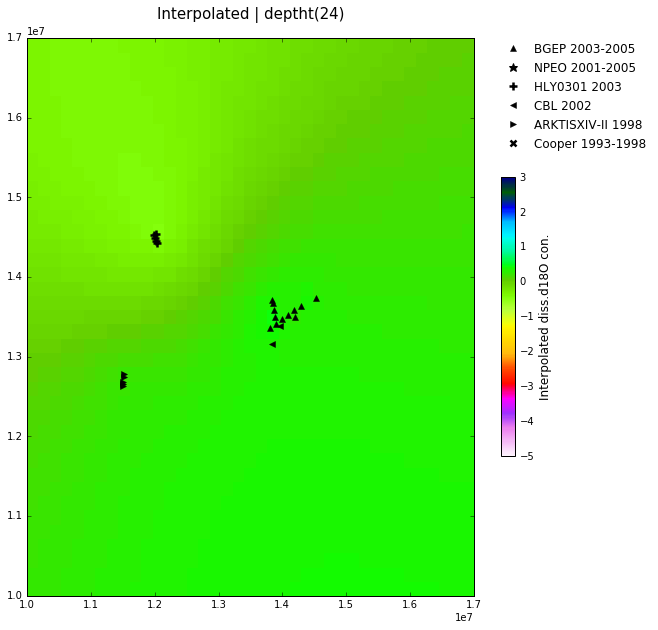

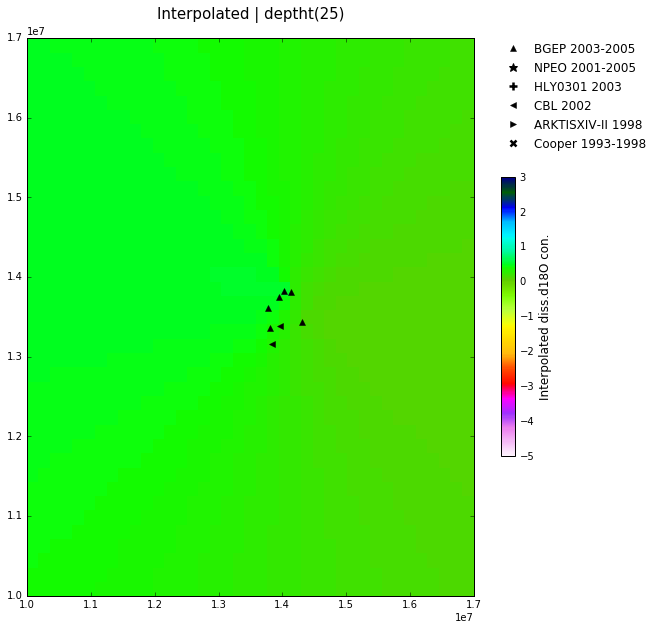

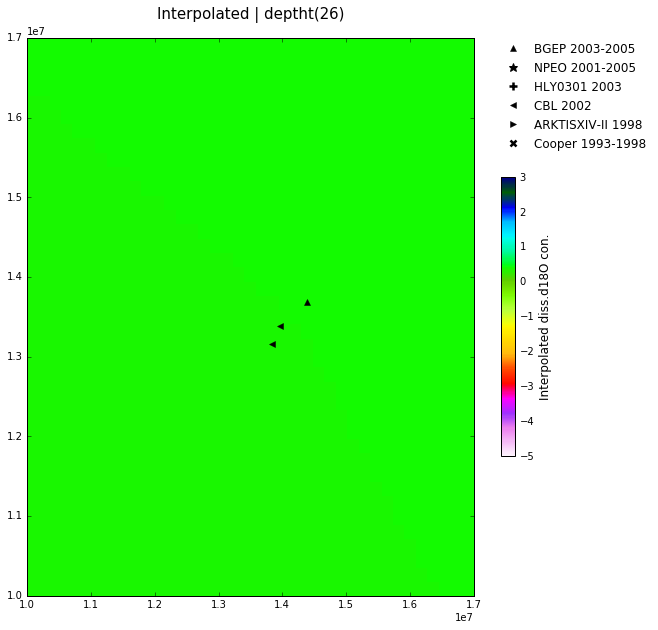

In [27]:
num_layer = 27
d18O_ini = np.empty([res, res, num_layer])
for i in range(num_layer):
    x_temp, y_temp, d18O_temp = remove_nan(x_all_trans, y_all_trans, out_surf[:, i])
    # plot cruises saperately
    for j in keys:
        x_cord[j], y_cord[j], _ = remove_nan(x_trans[j], y_trans[j], d18O_int[j][:, i])
        
    print('data points participated: {}'.format(len(d18O_temp)))# Check the the number of data
    # Kriging
    OK = OrdinaryKriging(x_temp, y_temp, d18O_temp, variogram_model='linear', verbose=False, enable_plotting=False)
    d18O_ini[:, :, i], ss = OK.execute('grid', listx_trans, listy_trans) # (gridx_trans, gridy_trans, Ba_int)
    # Plot
    fig=plt.figure(figsize=(10, 10))
    ax=fig.gca()
    ax.set_xlim(xylim[0], xylim[1])
    ax.set_ylim(xylim[0], xylim[1])
    CS = ax.pcolor(gridx_trans, gridy_trans, d18O_ini[:, :, i], vmin=-5, vmax=3, cmap=plt.cm.gist_ncar_r)
    
    ax.plot(x_cord['BGEP'] , y_cord['BGEP'] , 'k^', ms=6, mew=0.5, label='BGEP 2003-2005')
    ax.plot(x_cord['NPEO'] , y_cord['NPEO'] , 'k*', ms=9, mew=1.0, label='NPEO 2001-2005')
    ax.plot(x_cord['HLY']  , y_cord['HLY']  , 'k+', ms=8, mew=2.5, label='HLY0301 2003')
    ax.plot(x_cord['CBL']  , y_cord['CBL']  , 'k<', ms=6, mew=0.5, label='CBL 2002')
    ax.plot(x_cord['ARK14'], y_cord['ARK14'], 'k>', ms=6, mew=0.5, label='ARKTISXIV-II 1998')
    ax.plot(x_cord['Cooper'] , y_cord['Cooper'] , 'kx', ms=6, mew=2.5, label='Cooper 1993-1998')
    CBar = plt.colorbar(CS, shrink=0.5)
    CBar.set_label('Interpolated diss.d18O con.', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    LG = ax.legend(numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
    ax.set_title('Interpolated | deptht('+str(i)+')', fontsize=15, y=1.025) 

In [28]:
#coordinate_name=glob.glob('_data/NEMO/ORCA2_INPUT/coordinates*.nc')
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ORCA2_LIM_nemo_v3.4/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
#
lon_list = np.linspace(-180, 180, 360)
lat_list = np.linspace(60, 90, 30)
lonxy, latxy = np.meshgrid(lon_list, lat_list)

In [29]:
d18O_ini_xy = np.empty([np.size(lonxy, 0), np.size(lonxy, 1), num_layer])
d18O_ini_orca = np.empty([np.size(nav_lon, 0), np.size(nav_lon, 1), num_layer])
#hit = find_inland(nav_lon, nav_lat)
hit = np.zeros(latxy.shape)

In [30]:
for i in range(num_layer):
    int_temp = reporj_NEMOgrid(gridx, gridy, d18O_ini[:, :, i], lonxy, latxy, method='linear')
    int_temp_fill = reporj_NEMOgrid(gridx, gridy, d18O_ini[:, :, i], lonxy, latxy, method='nearest')
    #int_temp, lon_list = addcyclic(int_temp, lon_list)
    int_temp[np.isnan(int_temp)] = int_temp_fill[np.isnan(int_temp)]
    #int_temp[hit==1]=np.nan
    d18O_ini_xy[:, :, i] = int_temp

In [31]:
d18O_ini_masked = np.ma.masked_where(np.isnan(d18O_ini_xy), d18O_ini_xy)

((-180, 180), (60, 90))

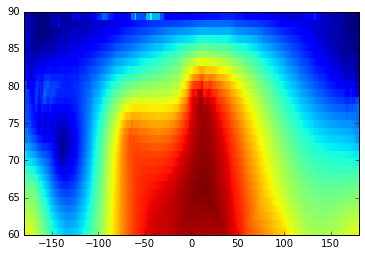

In [32]:
plt.pcolor(lonxy, latxy, d18O_ini_masked[:, :, 0])
ax = plt.gca(); ax.set_xlim(-180, 180), ax.set_ylim(60, 90)

In [33]:
ETOPO2_Arctic=scipy.io.loadmat('_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

In [34]:
# Adjust resolution
res_unit=5
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

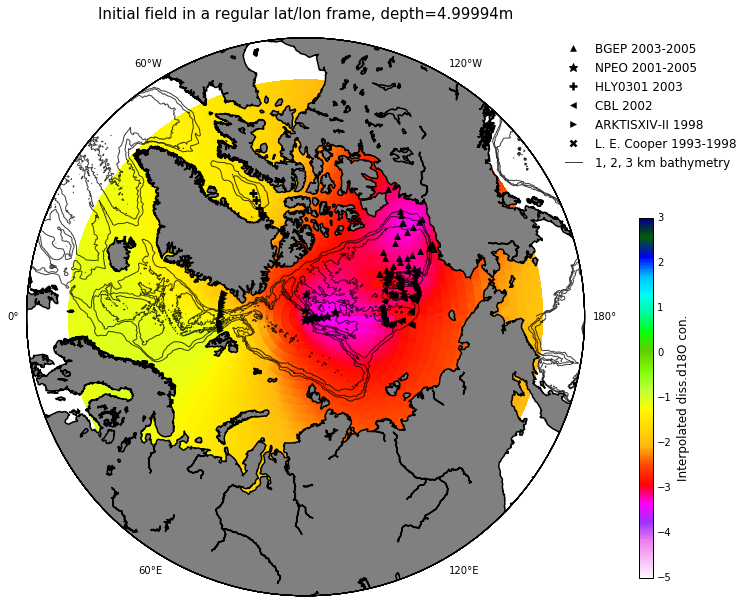

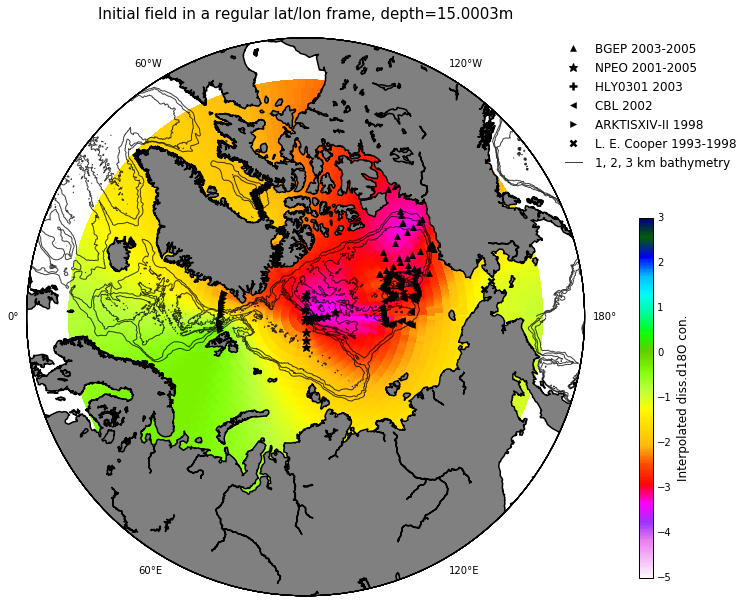

In [35]:
clevs=[1000, 2000, 3000]
for num in range(2):
    # Locations of CTDs
    for j in keys:
        x_cord[j], y_cord[j], _ = remove_nan(x_int[j], y_int[j], d18O_int[j][:, num])
    # Figures
    fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
    proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    gridx, gridy = proj(lonxy, latxy)
    topox, topoy = proj(lon_arctic, lat_arctic)
    for j in keys:
        x_cord[j], y_cord[j] = proj(x_cord[j], y_cord[j])
    CS = proj.pcolor(gridx, gridy, d18O_ini_masked[:, :, num], vmin=-5, vmax=3, cmap=plt.cm.gist_ncar_r)
    CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
    CS2.collections[0].set_label('1, 2, 3 km bathymetry')
    proj.plot(x_cord['BGEP'] , y_cord['BGEP'] , 'k^', ms=6, mew=0.5, label='BGEP 2003-2005')
    proj.plot(x_cord['NPEO'] , y_cord['NPEO'] , 'k*', ms=9, mew=1.0, label='NPEO 2001-2005')
    proj.plot(x_cord['HLY']  , y_cord['HLY']  , 'k+', ms=8, mew=2.5, label='HLY0301 2003')
    proj.plot(x_cord['CBL']  , y_cord['CBL']  , 'k<', ms=6, mew=0.5, label='CBL 2002')
    proj.plot(x_cord['ARK14'], y_cord['ARK14'], 'k>', ms=6, mew=0.5, label='ARKTISXIV-II 1998')
    proj.plot(x_cord['Cooper'] , y_cord['Cooper'] , 'kx', ms=6, mew=2.5, label='L. E. Cooper 1993-1998')
    #proj.plot(gridx.T, gridy.T, 'k-', lw=0.25)
    #proj.plot(gridx, gridy, 'k-', lw=0.25)
    cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.5]) 
    CBar = plt.colorbar(CS, ax=ax, cax=cbaxes) 
    CBar.set_label('Interpolated diss.d18O con.', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    LG = ax.legend(numpoints=1, bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
    ax.set_title('Initial field in a regular lat/lon frame, depth='+str(deptht[num])+'m', fontsize=15, y=1.025)

In [36]:
## Save
save_var = { 'd18O_ini_xy': d18O_ini_xy, 'nav_lon': nav_lon, 'nav_lat': nav_lat}
scipy.io.savemat('_data/Exchange/Temp_d18O_int.mat', mdict=save_var)